# Common Neighbor Rule in PyC Subgraph (Full)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.common_neighbor_rule import *
from utils.visualization import *

## Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_synapses

,pre,post
0,648518346349539437,648518346349531254
1,648518346349537978,648518346349537300
2,648518346349533058,648518346349538715
3,648518346349539333,648518346349539806
4,648518346349523975,648518346349537716
...,...,...
1976,648518346349539110,648518346349538440
1977,648518346349539110,648518346349523993
1978,648518346349539110,648518346349524141
1979,648518346349539110,648518346349539900


In [3]:
pyc_soma = pd.read_csv('data/soma.csv')
pyc_soma

,segmentation,segment_id,manual_id,loc,axon_len,dendrite_len
0,185,648518346349491311,466,[314028 159940 77280],0.000000,1441.069000
1,185,648518346349492130,499,[291484 145484 80960],0.000000,747.483938
2,185,648518346349492197,503,[270948 158088 86240],0.000000,586.186063
3,185,648518346349492682,163,[461372 212624 27640],643.547438,979.816375
4,185,648518346349493472,549,[431864 156576 85720],0.000000,0.000000
...,...,...,...,...,...,...
358,185,648518346349540048,80,[349132 163492 11480],961.385250,1321.124250
359,185,648518346349540051,259,[444892 247424 47480],61.243563,1999.626500
360,185,648518346349540053,102,[446104 253936 18320],56.518617,1612.330500
361,185,648518346349540055,139,[340468 248332 23400],46.961094,3101.869750


In [4]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [5]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


In [6]:
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}

In [7]:
g_full = get_thresholded_graph(g_actual, axls, -1)
print(nx.info(g_full))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


## Common Neighbor Rule

In [8]:
%%time
# calculate common neighbor stats in the observation
obs_cnr_stats = get_cnr_stats(g_full)

CPU times: user 3.65 s, sys: 0 ns, total: 3.65 s
Wall time: 3.66 s


- "undir_pair" - number of pairs with [bin] common neighbor
- "dir_spair" - number of pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_ppair" - number of pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_conn" - number of connected pairs with [bin] common neighbor
- "dir_sconn" - number of connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_pconn" - number of connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_uni_sconn" - number of unidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_uni_pconn" - number of unidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_bi_sconn" - number of bidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_bi_pconn" - number of bidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_perc" - percentage of pairs with [bin] common neighbor to be connected
- "dir_sperc" - percentage of pairs with [bin] strict common successor to be connected
- "dir_pperc" - percentage of pairs with [bin] strict common predcessor to be connected

In [9]:
obs_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,44285.0,62906.0,50026.0,465.0,1290.0,973.0,1280.0,955.0,10.0,18.0,0.010500,0.020507,0.019450
1,13395.0,1445.0,12213.0,436.0,163.0,527.0,155.0,517.0,8.0,10.0,0.032549,0.112803,0.043151
2,4545.0,723.0,2698.0,312.0,118.0,155.0,110.0,153.0,8.0,2.0,0.068647,0.163209,0.057450
3,1804.0,320.0,622.0,181.0,69.0,49.0,64.0,48.0,5.0,1.0,0.100333,0.215625,0.078778
4,802.0,144.0,117.0,132.0,26.0,11.0,26.0,11.0,0.0,0.0,0.164589,0.180556,0.094017
5,404.0,68.0,22.0,74.0,13.0,4.0,13.0,4.0,0.0,0.0,0.183168,0.191176,0.181818
6,182.0,39.0,5.0,37.0,18.0,0.0,18.0,0.0,0.0,0.0,0.203297,0.461538,0.000000
7,119.0,25.0,0.0,18.0,8.0,0.0,8.0,0.0,0.0,0.0,0.151261,0.320000,0.000000
8,63.0,14.0,0.0,22.0,7.0,0.0,7.0,0.0,0.0,0.0,0.349206,0.500000,0.000000
9,104.0,19.0,0.0,42.0,7.0,0.0,7.0,0.0,0.0,0.0,0.403846,0.368421,0.000000


In [10]:
%%time
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples = continuous_sample_cnr(g_full, samples=s, niters=int(1e4))


CPU times: user 6min 8s, sys: 236 ms, total: 6min 8s
Wall time: 6min 12s


In [11]:
cfg_cnr_stats, cfg_cnr_stats_std = cnr_mean_std(cfg_cnr_samples)

In [12]:
cfg_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,34182.14,53100.79,40099.80,507.31,1307.01,1038.93,1301.50,1026.35,5.51,12.58,0.014841,0.024614,0.025908
1,13633.70,1486.92,12425.28,452.72,182.66,493.58,177.01,486.44,5.65,7.14,0.033207,0.122861,0.039724
2,4648.30,718.08,2722.13,304.99,107.75,150.60,103.54,148.26,4.21,2.34,0.065603,0.150117,0.055308
3,1835.36,329.42,560.08,187.39,58.61,35.11,55.60,34.62,3.01,0.49,0.102073,0.178163,0.062574
4,818.52,151.03,111.98,112.18,30.60,7.53,28.82,7.39,1.78,0.14,0.137009,0.202407,0.067593
5,390.22,74.11,20.79,65.87,16.99,1.26,16.11,1.24,0.88,0.02,0.168715,0.229848,0.059205
6,200.18,38.21,4.00,38.79,9.97,0.26,9.32,0.26,0.65,0.00,0.193476,0.260903,0.062869
7,104.06,19.89,0.75,22.96,5.51,0.02,5.15,0.02,0.36,0.00,0.220466,0.275151,0.020000
8,56.81,11.50,0.17,13.65,3.17,0.00,2.93,0.00,0.24,0.00,0.240997,0.280881,0.000000
9,75.71,15.05,0.02,21.43,5.02,0.00,4.60,0.00,0.42,0.00,0.282173,0.335503,0.000000


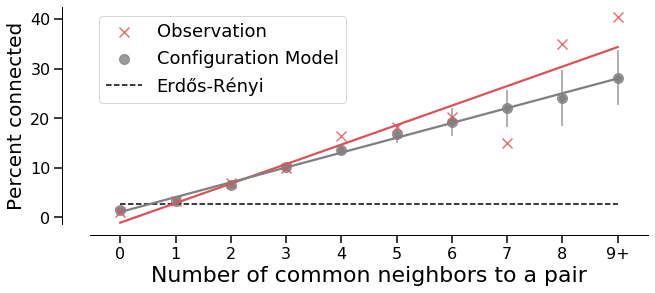

In [13]:
E, N = len(g_full.edges), len(g_full.nodes)
ER_p_null = (1 - E / (N*(N-1)))**2

plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null, figsize=(10,4), fname="full/full_cnr")

In [14]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8654259685162915, 9.495865324184074e-05)

In [15]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), cfg_cnr_stats["undir_perc"])

(0.9958430783893311, 8.178408973130952e-11)

## Common Neighbor Rule (Generalized Null Models)

In [16]:
%%time
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples_GE = continuous_sample_cnr_GE(g_full, samples=s, niters=int(1e4))


CPU times: user 7min 3s, sys: 264 ms, total: 7min 3s
Wall time: 7min 9s


In [17]:
cfg_cnr_stats_GE, cfg_cnr_stats_std_GE = cnr_mean_std(cfg_cnr_samples_GE)

In [18]:
cfg_cnr_stats_GE

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,34285.68,53122.33,40252.63,510.20,1306.39,1049.94,1298.13,1033.00,8.26,16.94,0.014882,0.024592,0.026084
1,13646.68,1480.36,12347.01,456.27,178.95,484.01,170.92,474.06,8.03,9.95,0.033437,0.120861,0.039203
2,4625.81,712.98,2669.05,305.21,108.02,142.90,102.08,139.81,5.94,3.09,0.065983,0.151542,0.053533
3,1801.46,324.72,543.36,185.67,56.56,33.48,53.08,32.71,3.48,0.77,0.103092,0.174233,0.061665
4,796.55,149.95,107.41,108.04,30.44,7.10,28.44,6.89,2.00,0.21,0.135554,0.203128,0.065941
5,379.01,72.37,20.44,63.61,16.59,1.31,15.41,1.28,1.18,0.03,0.167801,0.228849,0.067434
6,189.81,37.00,4.21,37.30,9.04,0.21,8.20,0.20,0.84,0.01,0.196273,0.244855,0.051119
7,98.45,19.48,0.78,20.98,5.25,0.04,4.77,0.04,0.48,0.00,0.212711,0.266427,0.020833
8,52.26,10.63,0.11,12.51,3.10,0.01,2.78,0.01,0.32,0.00,0.237843,0.296358,0.005000
9,69.29,15.18,0.00,19.21,4.66,0.00,4.19,0.00,0.47,0.00,0.274331,0.304330,0.000000


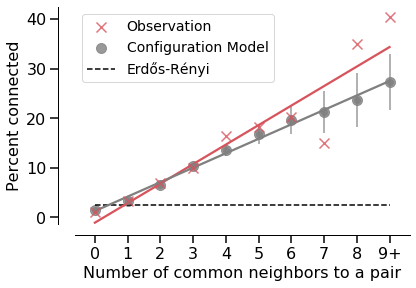

In [19]:
_, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_full)
ER_p_null_GE = 1 - 2*two_pr_GE["pr_uni"] - two_pr_GE["pr_bi"]

plot_cnr(obs_cnr_stats, cfg_cnr_stats_GE, cfg_cnr_stats_std_GE, ER_p_null_GE, 
         figsize=(6,4), fontsizes=(16, 16, 16, 14), fname="full/full_cnr_GE")

In [20]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8654259685162915, 9.495865324184074e-05)

In [21]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), cfg_cnr_stats_GE["undir_perc"])

(0.9944446754189665, 2.6101362220765795e-10)

## CFG v.s. Generalized ER

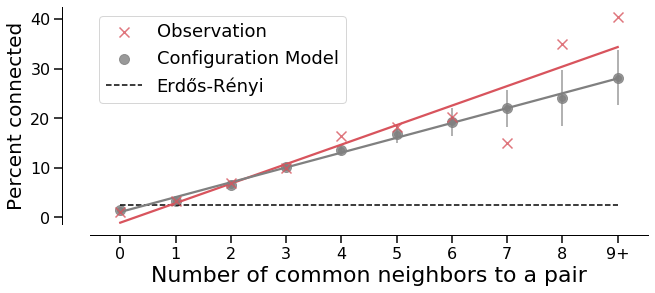

In [23]:
plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null_GE, figsize=(10,4), fname="full/full_cnr_CGE")